In [ ]:
# The code is based on the following tutorial: https://blog.gopenai.com/building-a-multi-pdf-rag-chatbot-langchain-streamlit-with-code-d21d0a1cf9e5
# Only thing is, that langgraph was used instead of langchain for the agentic programming

In [1]:
import os
import dotenv
dotenv.load_dotenv()

from PyPDF2 import PdfReader

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.messages import SystemMessage, HumanMessage

In [2]:
def pdf_reader(pdf_doc):
    text = ""
    for pdf in pdf_doc:
        pdf_reader = PdfReader(pdf)
        for page in pdf_reader.pages:
            text += page.extract_text()
    return text

def get_chunks(text):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    chunks = text_splitter.split_text(text)
    return chunks

In [3]:
embeddings = OpenAIEmbeddings()

def vector_store(text_chunks):
    vector_store = FAISS.from_texts(text_chunks, embedding=embeddings)
    vector_store.save_local("faiss_db")

In [4]:
text = pdf_reader(["scm-and-adv-planning.pdf",
                   "SCP_01_Overview.pdf",
                   "SCP_02_SC_Analysis.pdf",
                   "SCP_03_Basics_of_Modelling.pdf",
                   "SCP_04_Advanced_Planning.pdf",
                   "SCP_05_Structure_of_APS.pdf",
                   "SCP_07_Demand_Planning.pdf"])
chunks = get_chunks(text)
vector_store(chunks)

Defining tools

In [5]:
db_tool = FAISS.load_local("faiss_db", embeddings, allow_dangerous_deserialization=True)
retriever = db_tool.as_retriever()
retriever_tool = create_retriever_tool(retriever, "pdf_extractor", "This tool is to give answer to queries from the pdf")
tool = [retriever_tool]

In [6]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

llm = ChatOpenAI()
llm_with_tools = llm.bind_tools(tool)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [7]:
graph_builder = StateGraph(State)

tool_node = ToolNode(tools=tool)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [8]:
graph = graph_builder.compile(checkpointer=memory)

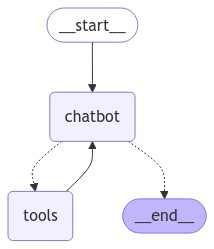

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
config = {"configurable": {"thread_id": "1"}}

Trying to add a system message

In [11]:
system_instructions = SystemMessage(content='''You are a PDF-based assistant with access to multiple PDFs provided by the user. Answer questions and provide information based strictly on the contents of these PDFs. Your responses must only contain verified information from the provided documents
    - If the requested information is not present in any of the PDFs, clearly state: 'The information is not available in the provided PDFs.'
    - When providing information, specify the document title (if available) and the exact page number or section to help the user locate the source. 
    - Avoid generalizations or assumptions beyond what is explicitly stated in the PDFs. 
    - Respond concisely, with clear and accurate answers based on the documents.
    - The answers should also be provided in bullet points''')

In [12]:
user_input = "What is the difference between structural and functional attributes?"

messages = [system_instructions, ("user", user_input)]

In [13]:
events = graph.stream(
    {"messages": messages}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the difference between structural and functional attributes?
================================== Ai Message ==================================
Tool Calls:
  pdf_extractor (call_42WmPsfOzMVXHWr0pxidi3Zf)
 Call ID: call_42WmPsfOzMVXHWr0pxidi3Zf
  Args:
    query: difference between structural and functional attributes
================================= Tool Message =================================
Name: pdf_extractor

entity, member, or location of a supply chain as well as “structural” attributes
describing the relations among its entities.
3.2 Functional Attributes
Functional attributes (see Tab. 3.1) of an entity are grouped into the four
categories
•procurement type,
•production type,
•distribution type and
•sales type.
Theprocurement type relates to the number (few...many) and type of
products to be procured, the latter one ranging from standard products to
highly speciﬁc products requiring spec

In [27]:
user_input = "A company produces the final items A and B. To produce 1 unit of final item A, 2 units of pre-product C and 3 units of pre-product D are required. For the production of 1 unit of pre-product D, 2 units of pre-product E are necessary. To produce 1 unit of final item B, 1 unit of pre-product C and 2 units of pre-product E are required. Lead times for the final items and for all pre-products are one week, each. Illustrate the bill of materials using a Gozinto-Graph. Also denominate the echelons of the bill of materials (Dispositionsstufen)."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

A company produces the final items A and B. To produce 1 unit of final item A, 2 units of pre-product C and 3 units of pre-product D are required. For the production of 1 unit of pre-product D, 2 units of pre-product E are necessary. To produce 1 unit of final item B, 1 unit of pre-product C and 2 units of pre-product E are required. Lead times for the final items and for all pre-products are one week, each. Illustrate the bill of materials using a Gozinto-Graph. Also denominate the echelons of the bill of materials (Dispositionsstufen).
================================== Ai Message ==================================

I will create a Gozinto-Graph to illustrate the bill of materials based on the information provided for the production of final items A and B. Additionally, I will denote the echelons (Dispositionsstufen) of the bill of materials.
A Gozinto-Graph representation of the bill of materials for t

In [87]:
snapshot = graph.get_state(config)

In [14]:
user_input = "What is a polycentric supply chain?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is a polycentric supply chain?
================================== Ai Message ==================================
Tool Calls:
  pdf_extractor (call_2j5EIZg4KqGgkMpPkOdyIUy9)
 Call ID: call_2j5EIZg4KqGgkMpPkOdyIUy9
  Args:
    query: polycentric supply chain
================================= Tool Message =================================
Name: pdf_extractor

of the supply chain over multiple years is considered. The ”cradle to grave”
approach is thus not only geographical but also temporal. Furthermore, it in-
tegrates the strategic capital budgeting decisions with the master planning.
It considers purchasing, manufacturing, distribution, and transportation cost
and capacities as well as the customer demand planning, which are geograph-
ically or organizationally dispersed components of a supply chain at a par-
ticular point in time. It also considers the full life cycle of diﬀerent products,
product po

In [77]:
existing_messages = snapshot.values["messages"][-1]
existing_messages.tool_calls

[]